# Reclasificación de AGEBS
Este es un nuevo repositorio para la reclasificación de AGEBS. El objetivo es crear un nuevo conjunto de AGEBS que sea más homogéneo y que permita una mejor comparación entre las diferentes variables de interés.

## Carga de librerías

In [135]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob

## Carga de datos

In [136]:
rename_quimicos = {
  'co': '$CO$',
  'hcho': '$HCHO$',
  'o3': '$O_3$',
  'so2': '$SO_2$',
  'no2': '$NO_2$'
}

### Datos de SENTINEL

In [137]:
sentinel_dir = "data/sentinel/AGEBS/month/*.csv"
sentinel_files = glob.glob(sentinel_dir)
sentinel_files.sort()
sentinel_files[:5]

['data/sentinel/AGEBS/month\\sum_CO_2018-11-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2018-12-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-01-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-02-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-03-01.csv']

In [138]:
pd.read_csv(sentinel_files[0]).head()

,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,system:index
0,0.052075,1,1,6,0600100010081,0081,00000000000000000000
1,0.023302,1,1,6,060010001019A,019A,00000000000000000001
2,0.008745,1,1,6,0600100010359,0359,00000000000000000002
3,0.077275,1,1,6,0600100010151,0151,00000000000000000003
4,0.076924,1,1,6,0600100010166,0166,00000000000000000004


In [139]:
sentinel_files[0].split("\\")[1].split("_")[1]

'CO'

In [140]:
def read_sentinel(files):
  df_full = pd.DataFrame()
  for f in files:
    quimico = f.split("\\")[1].split("_")[1]
    quimico = rename_quimicos[quimico.lower()]

    date = f.split("\\")[1].split("_")[2].split(".")[0]
    cols_to_keep = ["CVEGEO", "sum"]
    df = pd.read_csv(f, usecols=cols_to_keep)
    
    df["quimico"] = quimico
    df["date"] = date
    df_full = pd.concat([df_full, df])
  return df_full

df_sentinel = read_sentinel(sentinel_files)
df_sentinel.head()

,sum,CVEGEO,quimico,date
0,0.052075,0600100010081,$CO$,2018-11-01
1,0.023302,060010001019A,$CO$,2018-11-01
2,0.008745,0600100010359,$CO$,2018-11-01
3,0.077275,0600100010151,$CO$,2018-11-01
4,0.076924,0600100010166,$CO$,2018-11-01


In [141]:
# set df_sentinel from long to wide
df_sentinel_pivot = pd.pivot_table(df_sentinel,index=["CVEGEO", "date"],columns="quimico", values="sum").dropna()
df_sentinel_pivot.reset_index(inplace=True)
df_sentinel_pivot.head()

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$
0,0600100010081,2018-11-01,0.052075,0.000757,0.000491,1.018031,0.000308
1,0600100010081,2018-12-01,0.151151,0.001729,0.000560,1.030936,-0.000026
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786


In [142]:
# df_sentinel_pivot from monthly to yearly
df_sentinel_pivot["year"] = df_sentinel_pivot["date"].apply(lambda x: x[:4])
df_sentinel_pivot.head()

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,year
0,0600100010081,2018-11-01,0.052075,0.000757,0.000491,1.018031,0.000308,2018
1,0600100010081,2018-12-01,0.151151,0.001729,0.000560,1.030936,-0.000026,2018
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457,2019
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848,2019
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786,2019


In [143]:
# count months per year per ageb
df_sentinel_pivot["count"] = df_sentinel_pivot.groupby(["CVEGEO", "year"])["date"].transform("count")
df_sentinel_pivot = df_sentinel_pivot[df_sentinel_pivot["count"] > 10]
df_sentinel_pivot

quimico,CVEGEO,date,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,year,count
2,0600100010081,2019-01-01,0.211080,0.001839,0.000570,1.048855,0.001457,2019,12
3,0600100010081,2019-02-01,0.226947,0.001311,0.000558,0.991918,0.001848,2019,12
4,0600100010081,2019-03-01,0.272456,0.001478,0.000607,1.135778,0.001786,2019,12
5,0600100010081,2019-04-01,0.287970,0.001254,0.000635,1.111413,0.002244,2019,12
6,0600100010081,2019-05-01,0.321284,0.002491,0.000618,1.212021,0.000165,2019,12
...,...,...,...,...,...,...,...,...,...
26994,060100001138A,2022-07-01,0.026194,0.000248,0.000112,0.213964,0.000251,2022,11
26995,060100001138A,2022-08-01,0.027008,0.000163,0.000115,0.217196,0.000038,2022,11
26996,060100001138A,2022-09-01,0.025355,0.000123,0.000101,0.194637,0.000083,2022,11
26997,060100001138A,2022-10-01,0.033969,0.000197,0.000111,0.191612,0.000119,2022,11


In [144]:
df_sentinel_pivot.year.unique()

array(['2019', '2020', '2021', '2022'], dtype=object)

In [145]:
df_sentinel_sum = df_sentinel_pivot.groupby(["CVEGEO"]).sum().reset_index()

# devide by 4 to get average
for col in ["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$"]:
  df_sentinel_sum[col] = df_sentinel_sum[col] / 4
df_sentinel_sum.drop(columns=["count"], inplace=True)
df_sentinel_sum.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_4952\630139063.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sentinel_sum = df_sentinel_pivot.groupby(["CVEGEO"]).sum().reset_index()


quimico,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$
0,0600100010081,2.546332,0.017304,0.006821,13.622742,0.006580
1,0600100010109,3.176153,0.020710,0.008328,16.739348,0.007977
2,0600100010147,1.827610,0.012467,0.004884,9.781003,0.005085
3,0600100010151,3.791038,0.025777,0.010156,20.258907,0.009859
4,0600100010166,3.549575,0.023447,0.009389,18.672414,0.009003


### Datos del Indice de Marginación

In [146]:
im_src = "data/IM/IMU_2020.xls"
im = pd.read_excel(im_src, sheet_name="IMU_2020")
im = im[im["ENT"] == 6]
im_cols_to_keep = ["CVE_AGEB", "NOM_ENT","NOM_MUN", "NOM_LOC","POB_TOTAL","GM_2020"]
im = im[im_cols_to_keep]
im.rename(columns={"CVE_AGEB": "CVEGEO"}, inplace=True)
im

,CVEGEO,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
4815,0600100010081,Colima,Armería,Ciudad de Armería,1389,Medio
4816,0600100010109,Colima,Armería,Ciudad de Armería,1856,Medio
4817,0600100010147,Colima,Armería,Ciudad de Armería,1078,Medio
4818,0600100010151,Colima,Armería,Ciudad de Armería,1671,Medio
4819,0600100010166,Colima,Armería,Ciudad de Armería,1463,Alto
...,...,...,...,...,...,...
5309,0601000011341,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,945,Muy bajo
5310,0601000011356,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,255,Muy bajo
5311,0601000011360,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,414,Muy bajo
5312,0601000011375,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1878,Muy bajo


In [147]:
im.GM_2020.unique()

rename_gm = {
  'Muy alto': 5, 
  'Alto': 4,
  'Medio': 3,
  'Bajo': 2,
  'Muy bajo': 1
}

In [148]:
im["GM_2020"] = im["GM_2020"].apply(lambda x: rename_gm[x])
im.head()

,CVEGEO,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
4815,0600100010081,Colima,Armería,Ciudad de Armería,1389,3
4816,0600100010109,Colima,Armería,Ciudad de Armería,1856,3
4817,0600100010147,Colima,Armería,Ciudad de Armería,1078,3
4818,0600100010151,Colima,Armería,Ciudad de Armería,1671,3
4819,0600100010166,Colima,Armería,Ciudad de Armería,1463,4


### Recolección de metricas

In [149]:
df_sentinel_sum
im

metricas = pd.merge(df_sentinel_sum, im, on="CVEGEO")
metricas

,CVEGEO,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020
0,0600100010081,2.546332,0.017304,0.006821,13.622742,0.006580,Colima,Armería,Ciudad de Armería,1389,3
1,0600100010109,3.176153,0.020710,0.008328,16.739348,0.007977,Colima,Armería,Ciudad de Armería,1856,3
2,0600100010147,1.827610,0.012467,0.004884,9.781003,0.005085,Colima,Armería,Ciudad de Armería,1078,3
3,0600100010151,3.791038,0.025777,0.010156,20.258907,0.009859,Colima,Armería,Ciudad de Armería,1671,3
4,0600100010166,3.549575,0.023447,0.009389,18.672414,0.009003,Colima,Armería,Ciudad de Armería,1463,4
...,...,...,...,...,...,...,...,...,...,...,...
494,0601000011341,0.909909,0.006516,0.002780,5.075055,0.002552,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,945,1
495,0601000011356,0.782473,0.005305,0.002522,4.367105,0.002215,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,255,1
496,0601000011360,1.191221,0.008269,0.003564,6.475284,0.002907,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,414,1
497,0601000011375,1.859310,0.013077,0.005605,10.146833,0.005725,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,1878,1


In [150]:
metricas.NOM_MUN.unique()

array(['Armería', 'Colima', 'Comala', 'Coquimatlán', 'Cuauhtémoc',
       'Ixtlahuacán', 'Manzanillo', 'Minatitlán', 'Tecomán',
       'Villa de Álvarez'], dtype=object)

### Cargar agebs (shapefile)

In [151]:
colima = gpd.read_file("data/06_colima/06a.shp")
colima = colima[["CVEGEO", "area","geometry"]]
colima.head()

,CVEGEO,area,geometry
0,0600100010081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ..."
1,060010001019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ..."
2,0600100010359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ..."
3,0600100010151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ..."
4,0600100010166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ..."


In [152]:
colima_metricas = pd.merge(colima, metricas, on="CVEGEO")
colima_metricas["densidad"] = colima_metricas["POB_TOTAL"] / colima_metricas["area"]
colima_metricas.head()

,CVEGEO,area,geometry,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad
0,0600100010081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",2.546332,0.017304,0.006821,13.622742,0.006580,Colima,Armería,Ciudad de Armería,1389,3,4960.714286
1,060010001019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",1.143618,0.007762,0.003062,6.112355,0.002945,Colima,Armería,Ciudad de Armería,889,3,5926.666667
2,0600100010359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",0.424047,0.002876,0.001137,2.270659,0.001142,Colima,Armería,Ciudad de Armería,818,2,16360.000000
3,0600100010151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",3.791038,0.025777,0.010156,20.258907,0.009859,Colima,Armería,Ciudad de Armería,1671,3,3978.571429
4,0600100010166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",3.549575,0.023447,0.009389,18.672414,0.009003,Colima,Armería,Ciudad de Armería,1463,4,3568.292683


In [153]:
df_final = pd.DataFrame()

for mun in colima_metricas.NOM_MUN.unique():
  df_mun = colima_metricas[colima_metricas["NOM_MUN"] == mun]
  
  # normalize data by max min scaler
  cols_to_normalize = ["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]
  df_mun[cols_to_normalize] = (df_mun[cols_to_normalize] - df_mun[cols_to_normalize].min()) / (df_mun[cols_to_normalize].max() - df_mun[cols_to_normalize].min())

  df_final = pd.concat([df_final, df_mun])
df_final = gpd.GeoDataFrame(df_final)

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is tryin

In [154]:
# sum values by ageb of columns: $CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$, GM_2020, densidad
df_final["metrica"] = df_final[["$CO$","$HCHO$","$NO_2$","$O_3$","$SO_2$","GM_2020", "densidad"]].sum(axis=1)
df_final.head()

,CVEGEO,area,geometry,$CO$,$HCHO$,$NO_2$,$O_3$,$SO_2$,NOM_ENT,NOM_MUN,NOM_LOC,POB_TOTAL,GM_2020,densidad,metrica
0,0600100010081,0.28,"POLYGON ((2293464.136 773222.003, 2293464.942 ...",0.360105,0.374387,0.367944,0.365156,0.378404,Colima,Armería,Ciudad de Armería,1389,0.333333,0.240815,2.420145
1,060010001019A,0.15,"POLYGON ((2293790.913 773288.458, 2293796.024 ...",0.151035,0.156857,0.154249,0.152958,0.157463,Colima,Armería,Ciudad de Armería,889,0.333333,0.296206,1.402100
2,0600100010359,0.05,"POLYGON ((2292728.301 773695.719, 2292723.607 ...",0.043785,0.045469,0.044762,0.044415,0.047829,Colima,Armería,Ciudad de Armería,818,0.000000,0.894488,1.120748
3,0600100010151,0.42,"POLYGON ((2293388.338 773721.118, 2293407.275 ...",0.545624,0.567560,0.557554,0.552654,0.577758,Colima,Armería,Ciudad de Armería,1671,0.333333,0.184495,3.318979
4,0600100010166,0.41,"POLYGON ((2294660.453 773180.454, 2294661.055 ...",0.509635,0.514443,0.513976,0.507830,0.525731,Colima,Armería,Ciudad de Armería,1463,0.666667,0.160969,3.399250


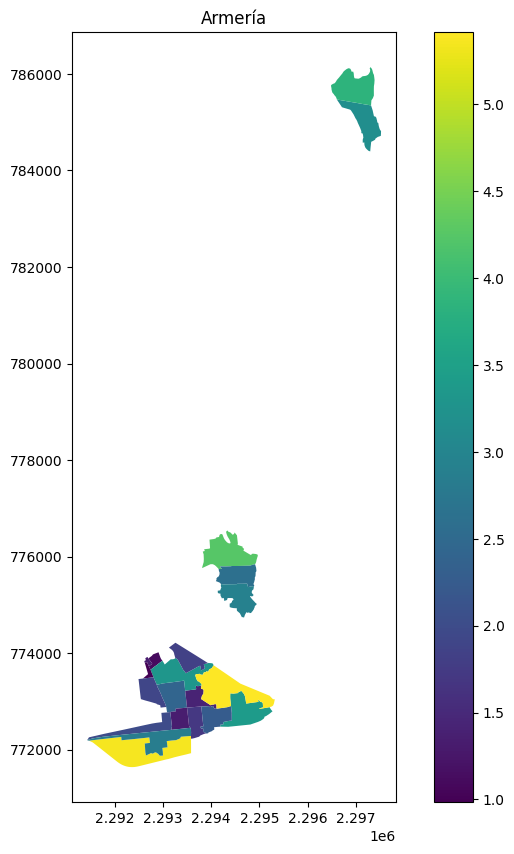

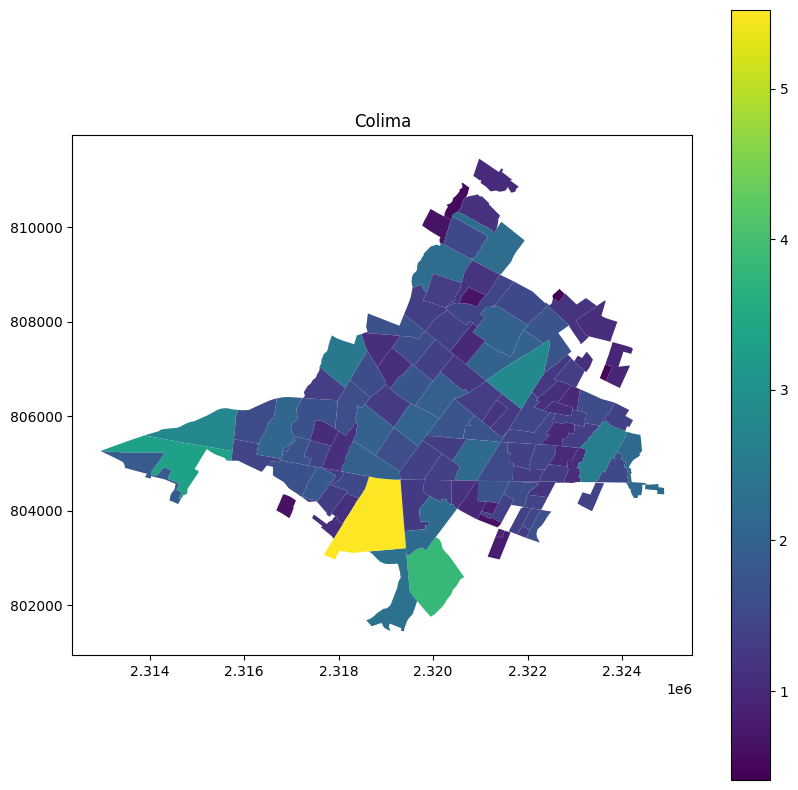

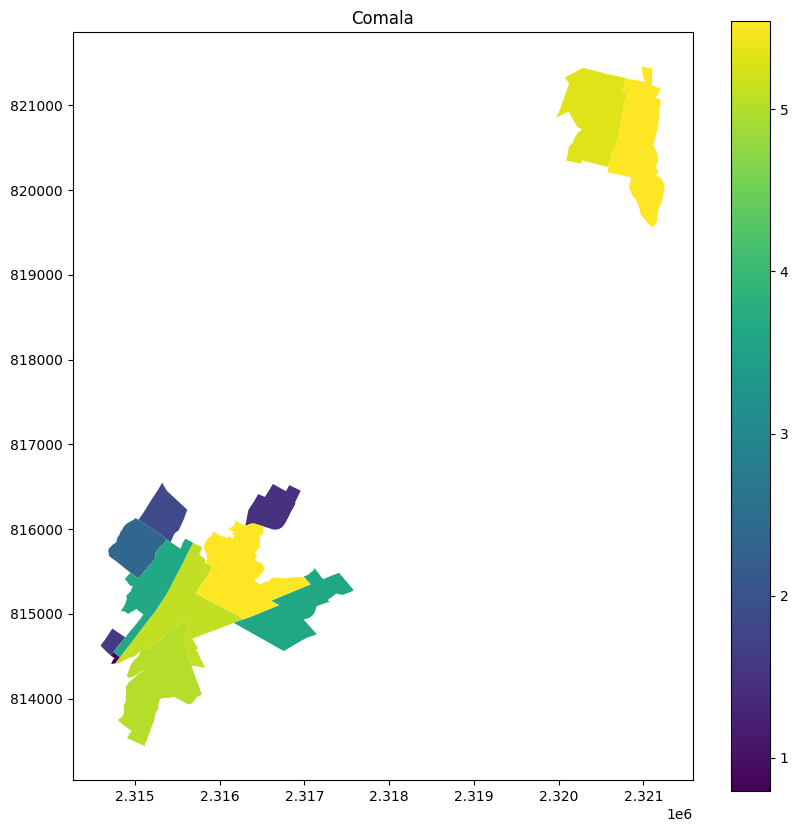

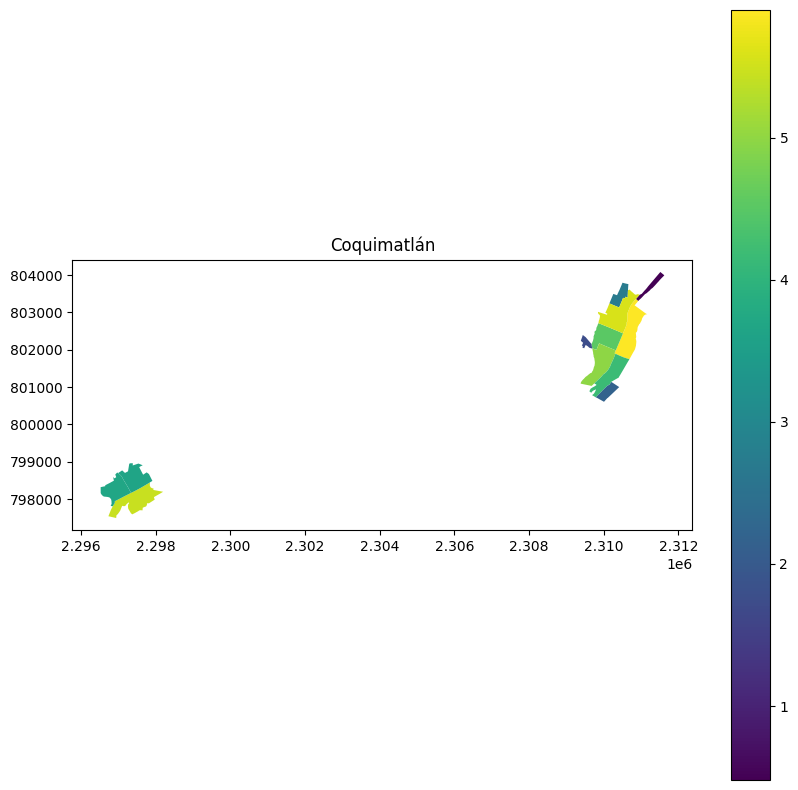

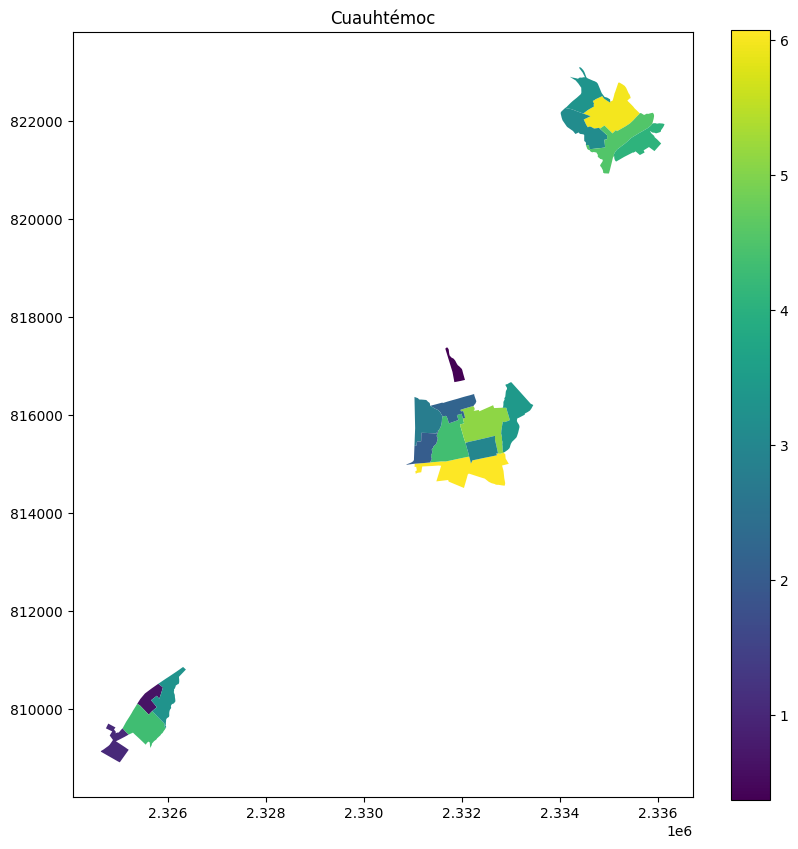

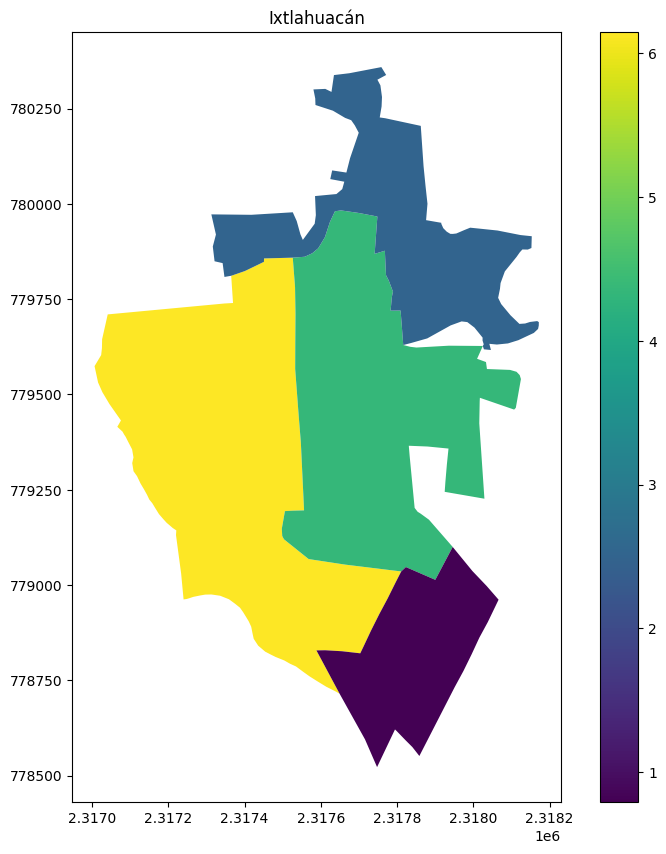

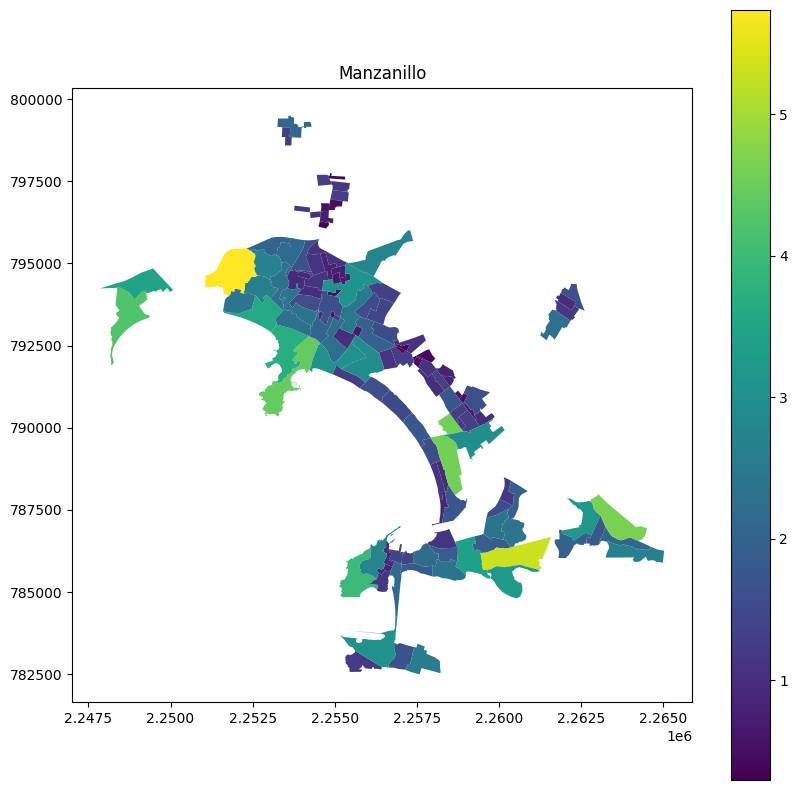

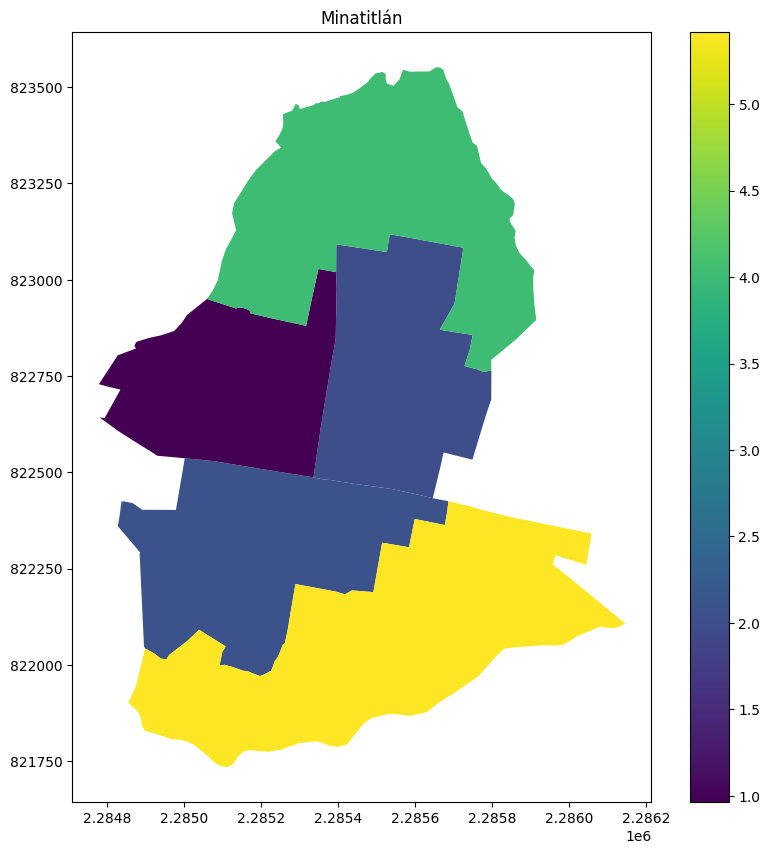

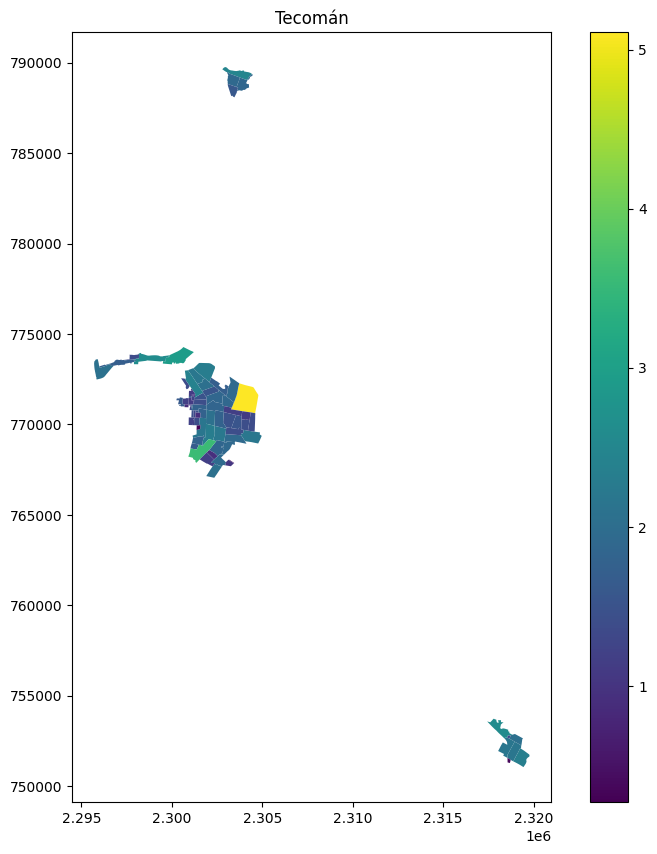

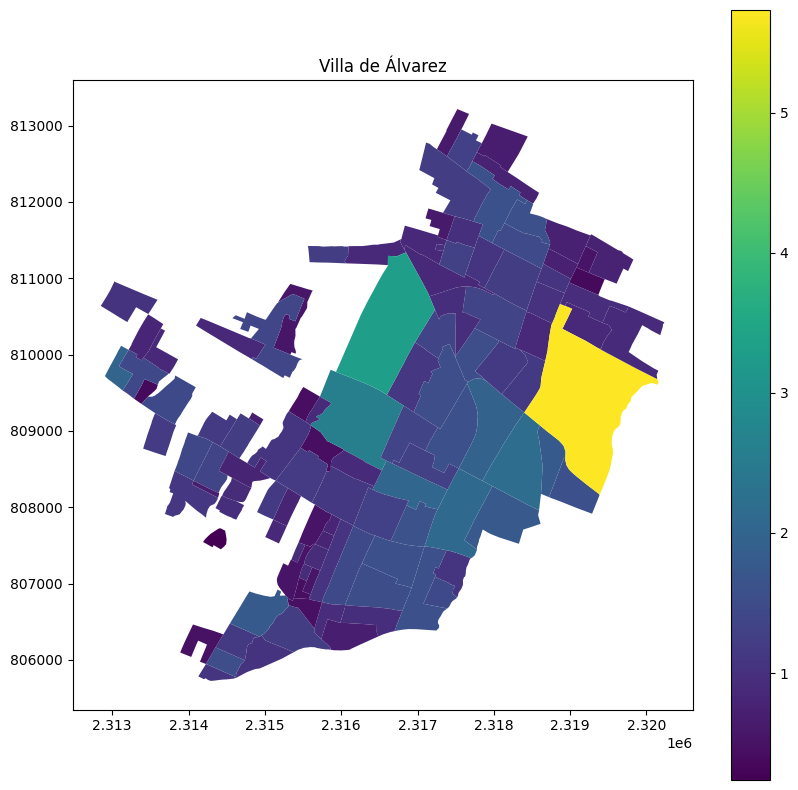

In [155]:
# plot each NOM_MUN
for mun in df_final.NOM_MUN.unique():
  df_mun = df_final[df_final["NOM_MUN"] == mun]
  df_mun.plot(column="metrica", legend=True, figsize=(10,10))
  plt.title(mun)
  plt.show()